In [10]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [11]:
import pandas as pd
import numpy as np
import pickle
import torch
import torch.nn as nn
from torch.utils.data import Dataset, TensorDataset
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from ast import literal_eval

In [ ]:
#data = pd.read_pickle('/content/drive/MyDrive/Big Data Bowl 2023/data/model_input_250k_random_sample.pkl')
data = pd.read_pickle('/content/drive/MyDrive/Home Projects/Big Data Bowl 2023/data/with_play_data_250k_testing.pkl')

In [12]:
data_dir = '/content/drive/MyDrive/Home Projects/Big Data Bowl 2023/data/'
plays = pd.read_csv(data_dir + "plays.csv")
games = pd.read_csv(data_dir + "games.csv")
plotting = pd.read_csv(data_dir + "xT_table_all_testing_final.csv")
players = pd.read_csv(data_dir + "players.csv")

plotting_all = plotting.merge(players, on = ['nflId'], how = 'inner')

In [ ]:
games.head()

,gameId,season,week,gameDate,gameTimeEastern,homeTeamAbbr,visitorTeamAbbr,homeFinalScore,visitorFinalScore
0,2022090800,2022,1,09/08/2022,20:20:00,LA,BUF,10,31
1,2022091100,2022,1,09/11/2022,13:00:00,ATL,NO,26,27
2,2022091101,2022,1,09/11/2022,13:00:00,CAR,CLE,24,26
3,2022091102,2022,1,09/11/2022,13:00:00,CHI,SF,19,10
4,2022091103,2022,1,09/11/2022,13:00:00,CIN,PIT,20,23


In [ ]:
new_data = data.merge(plays, on = ['gameId','playId'], how='inner')
new_data_games = new_data.merge(games, on = ['gameId'], how='inner')

In [ ]:
new_data_games['possesionScore'] = new_data_games.apply(lambda row: row['preSnapHomeScore'] if row['possessionTeam'] == row['homeTeamAbbr'] else row['preSnapVisitorScore'], axis=1)
new_data_games['defensiveScore'] = new_data_games.apply(lambda row: row['preSnapHomeScore'] if row['defensiveTeam'] == row['homeTeamAbbr'] else row['preSnapVisitorScore'], axis=1)
new_data_games['possessionWinProb'] = new_data_games.apply(lambda row: row['preSnapHomeTeamWinProbability'] if row['possessionTeam'] == row['homeTeamAbbr'] else row['preSnapVisitorTeamWinProbability'], axis=1)
new_data_games['defensiveWinProb'] = new_data_games.apply(lambda row: row['preSnapHomeTeamWinProbability'] if row['defensiveTeam'] == row['homeTeamAbbr'] else row['preSnapVisitorTeamWinProbability'], axis=1)
new_data_games['totalSeconds'] = new_data_games['gameClock'].apply(lambda x: int(x.split(':')[0]) * 60 + int(x.split(':')[1]))
new_data_games['defensiveWinProb'] = new_data_games.apply(lambda row: row['preSnapHomeTeamWinProbability'] if row['defensiveTeam'] == row['homeTeamAbbr'] else row['preSnapVisitorTeamWinProbability'], axis=1)

In [ ]:
final_df = new_data_games[['gameId', 'playId', 'frameId', 'four', 'three', 'two', 'one', 'current',
       'tackle_1', 'tackle_2', 'tackle_3', 'tackle_4', 'tackle_5', 'tackle_6',
       'tackle_7', 'tackle_8', 'tackle_9', 'tackle_10', 'tackle_11',
       'tackle_12','quarter','down','yardsToGo','yardlineNumber', 'totalSeconds', 'possesionScore', 'defensiveScore','absoluteYardlineNumber','possessionWinProb',
       'defensiveWinProb']]

In [ ]:
final_df

,gameId,playId,frameId,four,three,two,one,current,tackle_1,tackle_2,...,quarter,down,yardsToGo,yardlineNumber,totalSeconds,possesionScore,defensiveScore,absoluteYardlineNumber,possessionWinProb,defensiveWinProb
0,2022090800,56,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.9823384598581234, 1.3484585884884548, -0.13...",0.0,1.0,...,1,1,10,25,900,0,0,85,0.586653,0.413347
1,2022090800,56,2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.9823384598581234, 1.3484585884884548, -0.13...","[0.790808421685418, 1.4283941077210496, -0.733...",0.0,1.0,...,1,1,10,25,900,0,0,85,0.586653,0.413347
2,2022090800,56,3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.9823384598581234, 1.3484585884884548, -0.13...","[0.790808421685418, 1.4283941077210496, -0.733...","[0.5098976990321165, 1.656781305528464, -0.866...",0.0,1.0,...,1,1,10,25,900,0,0,85,0.586653,0.413347
3,2022090800,56,4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.9823384598581234, 1.3484585884884548, -0.13...","[0.790808421685418, 1.4283941077210496, -0.733...","[0.5098976990321165, 1.656781305528464, -0.866...","[0.07576294584065033, 1.668200665418835, -0.42...",0.0,1.0,...,1,1,10,25,900,0,0,85,0.586653,0.413347
4,2022090800,56,5,"[0.07576294584065033, 1.668200665418835, -0.42...","[0.5098976990321165, 1.656781305528464, -0.866...","[0.790808421685418, 1.4283941077210496, -0.733...","[0.9823384598581234, 1.3484585884884548, -0.13...","[-0.26899112287021976, 1.8965878632262487, -0....",0.0,1.0,...,1,1,10,25,900,0,0,85,0.586653,0.413347
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262019,2022110700,3686,72,"[-0.03915507706297314, 0.4349097972587982, -0....","[0.011919599783081736, 0.5262646763817639, -0....","[0.0629942766291366, 0.7203937945180658, -0.98...","[-0.0136177386399457, 0.8916841928736267, -1.0...","[-0.24345378444719232, 0.21794195934175478, -0...",0.0,0.0,...,4,1,10,46,151,27,13,64,0.996820,0.003180
262020,2022110700,3686,73,"[-0.24345378444719232, 0.21794195934175478, -0...","[-0.03915507706297314, 0.4349097972587982, -0....","[0.011919599783081736, 0.5262646763817639, -0....","[0.0629942766291366, 0.7203937945180658, -0.98...","[-0.5499018455235213, 0.09232900054767713, -0....",0.0,0.0,...,4,1,10,46,151,27,13,64,0.996820,0.003180
262021,2022110700,3686,74,"[-0.5499018455235213, 0.09232900054767713, -0....","[-0.24345378444719232, 0.21794195934175478, -0...","[-0.03915507706297314, 0.4349097972587982, -0....","[0.011919599783081736, 0.5262646763817639, -0....","[-0.652051199215631, 0.0009741214247113909, -0...",0.0,0.0,...,4,1,10,46,151,27,13,64,0.996820,0.003180
262022,2022110700,3686,75,"[-0.652051199215631, 0.0009741214247113909, -0...","[-0.5499018455235213, 0.09232900054767713, -0....","[-0.24345378444719232, 0.21794195934175478, -0...","[-0.03915507706297314, 0.4349097972587982, -0....","[-0.7158945452731994, -0.10180011758862507, -0...",0.0,0.0,...,4,1,10,46,151,27,13,64,0.996820,0.003180


In [ ]:
final_df.to_pickle('with_play_data_250k_testing.pkl')

In [42]:
plotting_viz = plotting_all.iloc[:20,:]
plotting_viz['xT'] = plotting_viz['xT'].round(3)
plotting_viz['xTDiff'] = plotting_viz['xTDiff'].round(3)

<ipython-input-42-4fdad32c49cd>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plotting_viz['xT'] = plotting_viz['xT'].round(3)
<ipython-input-42-4fdad32c49cd>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plotting_viz['xTDiff'] = plotting_viz['xTDiff'].round(3)


In [44]:
plotting_viz_final = plotting_viz[['displayName','position','playId','tackle','assist','xT','xTDiff']]

In [45]:
plotting_viz_final = plotting_viz_final.sort_values(by='xTDiff', ascending=True)
plotting_viz_final

,displayName,position,playId,tackle,assist,xT,xTDiff
19,Nasir Adderley,FS,140,10.0,5.0,6.040,6.460
18,Jordan Davis,DT,73,7.0,3.0,2.026,6.474
17,Myles Hartsfield,FS,195,22.0,6.0,18.510,6.490
16,Derwin James,FS,162,15.0,13.0,14.916,6.584
15,Christian Wilkins,DT,161,12.0,7.0,8.914,6.587
14,D.J. Jones,DT,118,10.0,4.0,4.845,7.155
13,Leki Fotu,DT,98,7.0,7.0,2.276,8.224
12,Kyle Hamilton,FS,89,10.0,3.0,3.211,8.289
11,Jevon Holland,FS,205,16.0,3.0,9.049,8.451
10,Minkah Fitzpatrick,FS,156,17.0,10.0,13.414,8.586


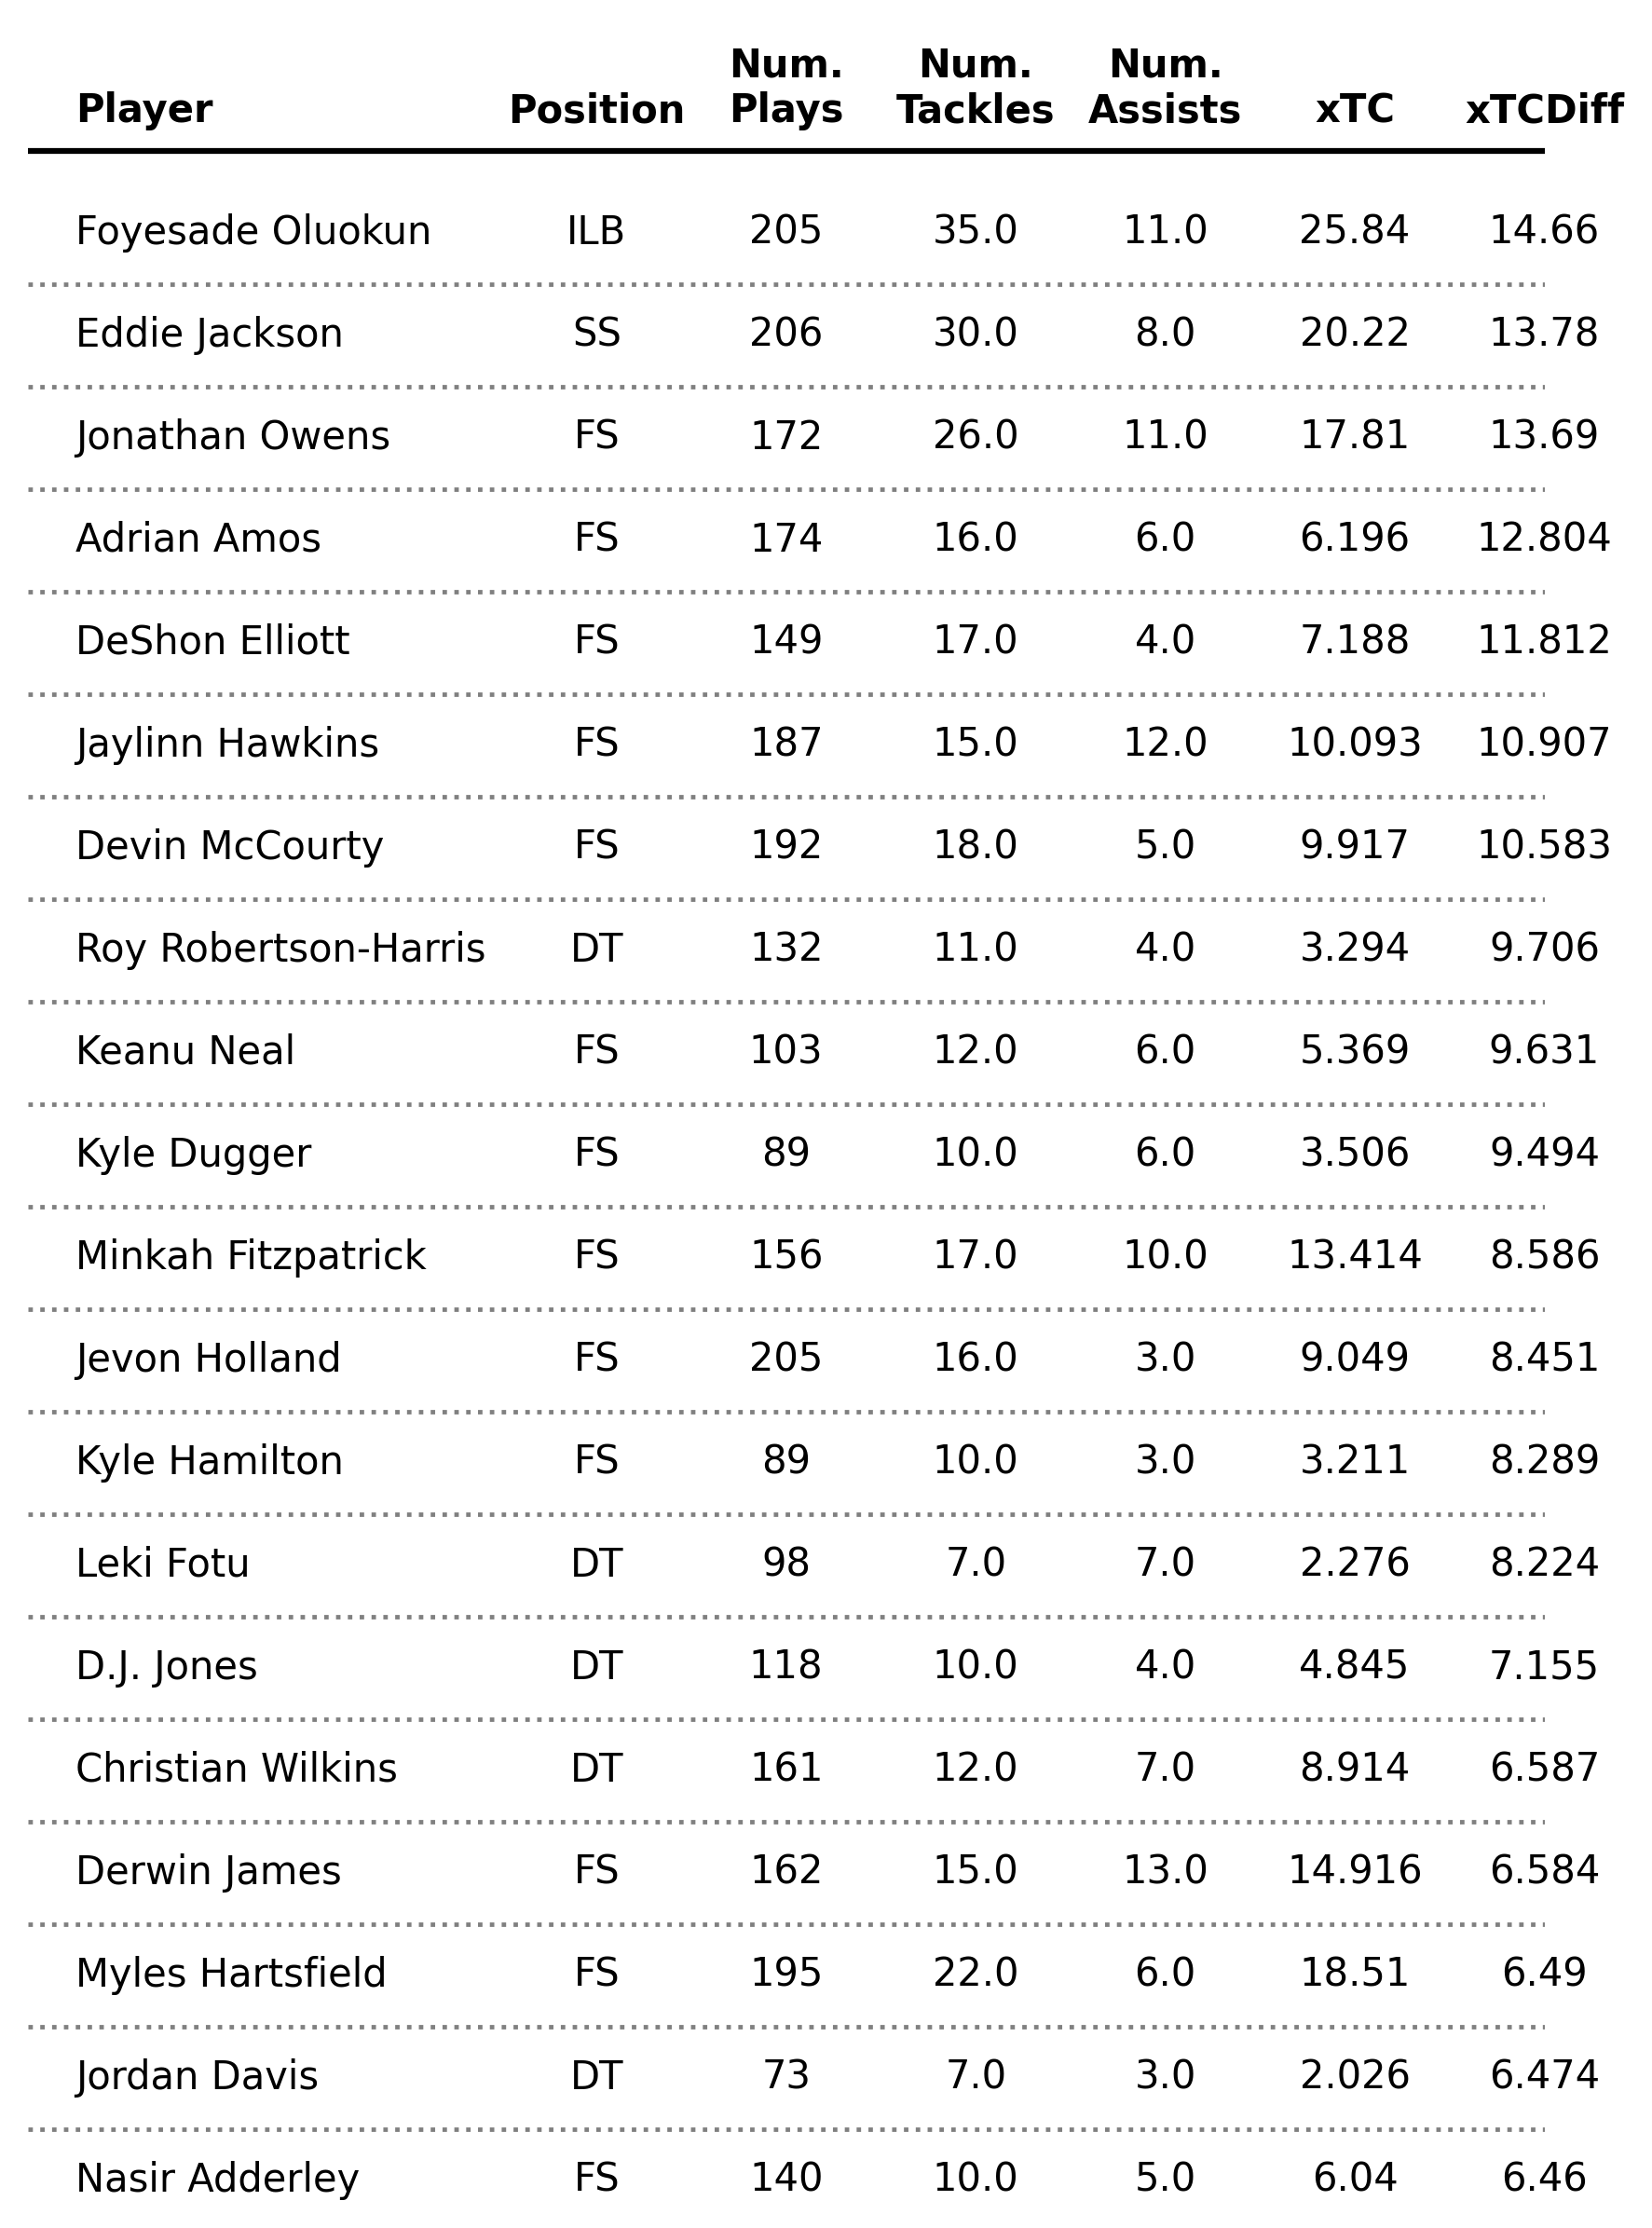

<Figure size 640x480 with 0 Axes>

In [46]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(7,10), dpi=300)
ax = plt.subplot()

ncols = 7
nrows = plotting_viz_final.shape[0]

ax.set_xlim(0, ncols + 1)
ax.set_ylim(0, nrows + 1)

positions = [0.25, 3, 4, 5, 6, 7, 8]
columns = ['displayName','position', 'playId','tackle','assist','xT','xTDiff']

# Add table's main text
for i in range(nrows):
    for j, column in enumerate(columns):
        if j == 0:
            ha = 'left'
        else:
            ha = 'center'
        ax.annotate(
            xy=(positions[j], i),
            text=plotting_viz_final[column].iloc[i],
            ha=ha,
            va='center'
        )

# Add column names
column_names = ['Player', 'Position', 'Num.\nPlays', 'Num.\nTackles','Num.\nAssists', 'xTC', 'xTCDiff']
for index, c in enumerate(column_names):
        if index == 0:
            ha = 'left'
        else:
            ha = 'center'
        ax.annotate(
            xy=(positions[index], nrows),
            text=column_names[index],
            ha=ha,
            va='bottom',
            weight='bold'
        )

# Add dividing lines
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [nrows -0.2, nrows-0.2], lw=1.5, color='black', marker='', zorder=4)
#ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [-2, -2], lw=1.5, color='black', marker='', zorder=4)
for x in range(1, nrows):
    ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [x-0.5, x-0.5], lw=1.15, color='gray', ls=':', zorder=3 , marker='')


ax.set_axis_off()
plt.show()

plt.savefig(
    'UnderperformingxTC.png'
)